In [9]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os
from torch import nn, optim
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import pickle
import librosa
import librosa.display

class Conv1DNet(nn.Module):
    def __init__(self):
        super(Conv1DNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(512, 512, 2),
            nn.LeakyReLU(),
            nn.Conv1d(512, 512, 2),
            nn.LeakyReLU(),
            nn.Conv1d(512, 256, 2),
            nn.LeakyReLU(),
            nn.Conv1d(256, 256, 2),
            nn.LeakyReLU(),
            nn.Conv1d(256, 256, 2),
            nn.LeakyReLU(),
            nn.Conv1d(256, 128, 2),
            nn.LeakyReLU(),
            nn.Conv1d(128, 64, 2),
            nn.LeakyReLU(),
            nn.Conv1d(64, 32, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 64, 2),  # Inverse of the last Conv1d in encoder
            nn.LeakyReLU(),
            nn.ConvTranspose1d(64, 128, 2),  # Mirroring the corresponding encoder layer
            nn.LeakyReLU(),
            nn.ConvTranspose1d(128, 256, 2),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(256, 256, 2),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(256, 256, 2),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(256, 512, 2),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(512, 512, 2),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(512, 512, 2),
        )


    def forward(self, x):
        latent = self.encoder(x)
        reconst = self.decoder(latent)
        return reconst
    
model = Conv1DNet()
state_dict = torch.load('./out/violin/model_1515_0.006151.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
# Load audio file
audio_path = '../../data/violin/2242_3.wav'
y, sr = librosa.load(audio_path)

y = librosa.resample(y, orig_sr=sr, target_sr=44100)
sr = 44100

# chunck = 5089 // 6
# y1 = y[:chunck]
# y2 = y[chunck*1:chunck*2]
# y3 = y[chunck*2:chunck*3]
# y4 = y[chunck*3:chunck*4]
# y5 = y[chunck*4:chunck*5]
# y6 = y[chunck*5:]

S = librosa.feature.melspectrogram(y=y, n_mels=512, sr=sr, n_fft=1024, hop_length=256)

#############################
specs = torch.tensor(S)
specs = specs.unsqueeze(0)
print(specs.shape)
specs = model(specs)
specs = specs.squeeze(0)
print(specs.shape)
#############################]

torch.Size([1, 512, 862])
torch.Size([512, 862])


In [11]:
from IPython.display import Audio

# Display and play the audio
Audio(data=y, rate=sr)

In [12]:
import numpy as np

stft = librosa.feature.inverse.mel_to_stft(specs.detach().numpy(), sr=sr, n_fft=1024)
print(stft.shape)
y_inv = librosa.griffinlim(stft, hop_length=256)
print(y_inv.shape)


(513, 862)
(220416,)


In [13]:
from IPython.display import Audio

# Display and play the audio
Audio(data=y_inv, rate=sr)

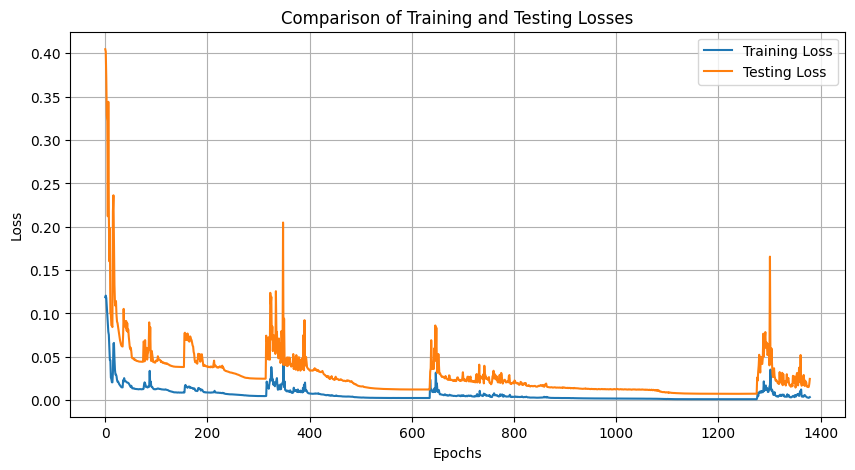

In [77]:
import pickle
import matplotlib.pyplot as plt

# Load data from pickle files
def load_pickle(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data

test_loss = load_pickle('./out/violin/test_loss.pkl')
train_loss = load_pickle('./out/violin/train_loss.pkl')
t_loss = []
r_loss = []
for train in train_loss:
    if train <= 5:
        t_loss.append(train)
for train in test_loss:
    if train <= 5:
        r_loss.append(train)
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Training Loss')
plt.plot(r_loss, label='Testing Loss')
plt.title('Comparison of Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
